In [ ]:
import sys
sys.path.append('../')

In [2]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date

In [4]:
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 4}) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
RAD_DATA_PATH = '../data/clc/rad/'

In [6]:
clc = load_clc_db_records(RAD_DATA_PATH)

In [7]:
clc = construct_features_batch(clc)

../utils/features.py:28: RuntimeWarning: divide by zero encountered in log
  df['Returns_Daily'] = np.log(df['Settle']).diff()
/home/maxlamberti/anaconda3/envs/AI_ENV/lib/python3.6/site-packages/pandas/core/algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [8]:
df = merge_asset_data(clc, create_time_asset_index=True)

In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Settle', 'Volume', 'Open_Interest',
       'Returns_Daily', 'Next_Returns_Daily', 'Sigma', 'Norm_Returns_Daily',
       'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
       'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
       'MACD_16_48', 'MACD_32_96', 'Asset_Col', 'Date_Col'],
      dtype='object')

In [11]:
feature_labels = [
   'Norm_Returns_Daily', 'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
   'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
   'MACD_16_48', 'MACD_32_96'
]

In [12]:
df.dropna(inplace=True)

In [13]:
from datetime import datetime
min_date = df.groupby('Asset_Col').Date_Col.min()
max_date = df.groupby('Asset_Col').Date_Col.max()
data_counts = df.groupby('Asset_Col').Date_Col.count()
mask = ((max_date >= datetime(2020, 1, 1)) & (min_date <= datetime(1995, 1, 1)) & (data_counts > 4000))
df = df[df.Asset_Col.isin(data_counts.index[mask].values)]

In [14]:
date_breakpoints = [datetime(1995, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]

In [15]:
data_set = split_by_date(df, date_breakpoints)

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(6, activation='relu', kernel_initializer='normal', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear', kernel_initializer='normal'))
    return model

In [34]:
model = create_mlp(len(feature_labels))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 54        
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 28        
_________________________________________________________________
dropout_4 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 87
Trainable params: 87
Non-trainable params: 0
_________________________________________________________________


In [50]:
def returns_loss(target_data, size_prediction):
    sigma_tgt=0.15
    next_period_return = target_data[:, 0]
    sigma_t = target_data[:, 1]
    num_data_points = size_prediction.shape[0].value
#     print(type(num_data_points.value))
    loss = -np.sum(size_prediction * sigma_tgt * next_period_return / sigma_t) / num_data_points
    return loss

model.compile(
    loss = returns_loss,
    optimizer='adam'
)

In [63]:
2 ** 8

256

In [103]:
epochs = 10000
batch_size = 2 ** 11

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import time
temp_series = pd.DataFrame()
for data_idx, data_series in enumerate(data_set):
    
    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    val_series = data_set[data_idx + 1]
    
    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series
    
    # construct features and targets
    X = data_series[feature_labels].values
    y = data_series[['Next_Returns_Daily', 'Sigma']].values
    X_val = val_series[feature_labels].values
    y_val = val_series[['Next_Returns_Daily', 'Sigma']].values
    
#     print(X.shape, y.shape)
#     print(returns_loss(y, 0.5 * np.ones(X.shape[0])))
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('../models/best_mlp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    batch_logger = NBatchLogger(2, epochs)
    
    history = model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1, 
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[earlyStopping, mcp_save]
    )
    break

Train on 65394 samples, validate on 65090 samples
Epoch 1/10000
65394/65394 [==============================] - 0s 5us/step - loss: -0.0368 - val_loss: -0.7665
Epoch 2/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0432 - val_loss: -0.7649
Epoch 3/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0381 - val_loss: -0.7659
Epoch 4/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0372 - val_loss: -0.7698
Epoch 5/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0403 - val_loss: -0.7738
Epoch 6/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0406 - val_loss: -0.7749
Epoch 7/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0421 - val_loss: -0.7757
Epoch 8/10000
65394/65394 [==============================] - 0s 4us/step - loss: -0.0375 - val_loss: -0.7786
Epoch 9/10000
65394/65394 [==============================] - 0s 4us/step - los

In [77]:
history

In [61]:
def returns_loss_dummy(target_data, size_prediction):
    sigma_tgt=0.15
    next_period_return = target_data[:, 0]
    sigma_t = target_data[:, 1]
    num_data_points = size_prediction.shape[0]
#     print(type(num_data_points.value))
    loss = -np.sum(size_prediction * sigma_tgt * next_period_return / sigma_t)# / num_data_points
    return loss
print(returns_loss_dummy(y_val, 1 * np.ones(X_val.shape[0])))

-162.26497283207522


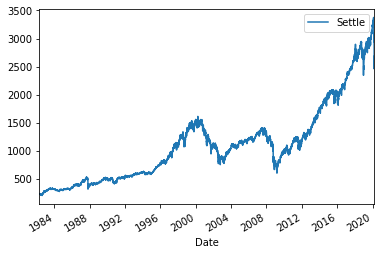

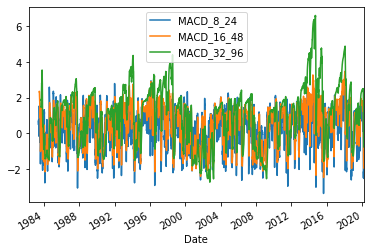

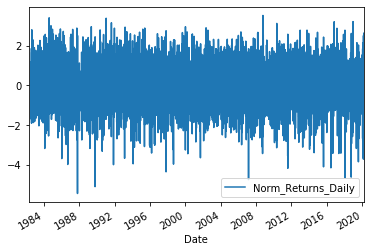

In [67]:
df.plot(x='Date', y=['Settle'])
plt.show()
df.plot(x='Date', y=['MACD_8_24', 'MACD_16_48', 'MACD_32_96'])
plt.show()
df.plot(x='Date', y=['Norm_Returns_Daily'])


In [31]:
0.007239 * np.sqrt(252)

0.11491556244477943